#

<b><font size="6">Data-Driven Marketing with Google Merch Store Customer Data</font>   
    
    
    Notebook by Allison Kelly - allisonkelly42@gmail.com

    Blog post - placeholder

    Presentation - placeholder

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Cleaning-and-EDA" data-toc-modified-id="Data-Cleaning-and-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning and EDA</a></span><ul class="toc-item"><li><span><a href="#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtaining the data</a></span></li><li><span><a href="#Cleaning-the-Data" data-toc-modified-id="Cleaning-the-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Cleaning the Data</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li></ul></li><li><span><a href="#Market-Segmentation-and-the-RFM-Model" data-toc-modified-id="Market-Segmentation-and-the-RFM-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Market Segmentation and the RFM Model</a></span><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Customer-Segmentation---Unsupervised-Machine-Learning-with-Kmeans" data-toc-modified-id="Customer-Segmentation---Unsupervised-Machine-Learning-with-Kmeans-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Customer Segmentation - Unsupervised Machine Learning with Kmeans</a></span></li></ul></li><li><span><a href="#Customer-Lifetime-Value" data-toc-modified-id="Customer-Lifetime-Value-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Customer Lifetime Value</a></span><ul class="toc-item"><li><span><a href="#Assumptions" data-toc-modified-id="Assumptions-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Assumptions</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Basic-Analysis-with-the-BG/NBD-Model" data-toc-modified-id="Basic-Analysis-with-the-BG/NBD-Model-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Basic Analysis with the BG/NBD Model</a></span></li><li><span><a href="#Customer-Lifetime-Value-with-the-Gamma-Gamma-Model" data-toc-modified-id="Customer-Lifetime-Value-with-the-Gamma-Gamma-Model-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Customer Lifetime Value with the Gamma Gamma Model</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

# Introduction

Leveraging machine learning and AI with the massive amounts of consumer history, web traffic, and product reviews can have a measurable impact on marketing campaigns. By harnessing the power of statistical and analytical tools, patterns untracked by basic dashboards can be unearthed, translating into higher conversion rates over traditional marketing strategies. The following notebook is one such demonstration of this power.

Part one explores customer purchase history on the <a href="https://shop.googlemerchandisestore.com/">Google Merchandise Store.</a> By using kmeans clustering algorithm, I will segment each customer by behavior in order to develop proper marketing strategies.

Part two will predict and measure customer lifetime value with the BG/NBD and Gamma Gamma models which can be used to develop advertising budgets by determining the cost of conversion.


# Imports

In [1]:
import pandas as pd

# Plot data
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly.offline as pyoff
import plotly.graph_objs as go

import time
import datetime
import numpy as np
import json # for data cleaning

import warnings # Ignoring warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import poisson

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Package for CLV modeling
import lifetimes
from lifetimes.plotting import *
from lifetimes.utils import *

# Data Cleaning and EDA

## Obtaining the data

This dataset was derived from the Google Merchandise Store demo account as provided by Google BigQuery on Kaggle. You can find the data <a href="https://www.kaggle.com/c/ga-customer-revenue-prediction">here.</a> 

In [2]:
df = pd.read_csv('train.csv') # loading and checking out the dataset
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [3]:
print(df.info())

print('\n\nNumber of individual visitors to the Google Merch Store: ', 
      len(df.fullVisitorId.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB
None


Number of individual visitors to the Google Merch Store:  742735


The dataframe is consisted of 903,653 datapoints describing visits to the Google Merch Store with 742,753 unique visitors. Most features consist of objects, though the integers are either dates, times or immutable ID numbers that should be categorized accordingly. 

## Cleaning the Data

In [4]:

def datetime_edits(dataframe):
    
    """This function changes the two columns 
    with dates/times into datetime objects.
    To be used with dataframes with similar
    setup to this one."""
    
    try:
        dataframe.date.astype(str)
        dataframe.date = pd.to_datetime(dataframe.date, 
                                        format='%Y%m%d')
    except:
        print("Your dataframe does not contain a 'date' column.")
        
    try:
        dataframe.visitStartTime = pd.to_datetime(dataframe.visitStartTime, unit='s')
    
    except:
        print("Your dataframe does not containt a 'visitStartTime' column.")
    
    # confirming proper edits were made
    return "Date column:", dataframe.date.dtype, "Time column:", dataframe.visitStartTime.dtype


In [5]:
datetime_edits(df)

('Date column:', dtype('<M8[ns]'), 'Time column:', dtype('<M8[ns]'))

In [6]:
# changing immutable IDs to strings
df.visitId = df.visitId.astype(str)

In [7]:

def unpack_col(df, col):
    
    '''Some column values are dictionary-like strings.
    This function unpacks those values, creating new
    columns for each key that can then be analyzed 
    as separate features. Returns dataframe of 
    unpacked column, not including original column.
    '''
    
    df[col] = df[col].dropna().apply(json.loads)
    unpacked_df = df[col].apply(pd.Series)
        
    return unpacked_df
        
geo_df = unpack_col(df, 'geoNetwork')
totals_df = unpack_col(df, 'totals')


In [8]:
df_expanded = pd.concat([df, geo_df, totals_df], axis=1)

In [9]:
df_expanded.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,...,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
1,Organic Search,2016-09-02,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,...,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
2,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
3,Organic Search,2016-09-02,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{'continent': 'Asia', 'subContinent': 'Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN
4,Organic Search,2016-09-02,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{'continent': 'Europe', 'subContinent': 'North...",27294437909732085_1472822600,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,...,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,NaN,NaN


In [10]:
# Dropping unpacked columns 

df_expanded = df_expanded.drop(['geoNetwork','totals'], axis=1)

The nested information in the device and trafficSource columns would be necessary for an analysis of ad quality, but we're concerned with what the customer does once they get to the store, not how they get there. We'll drop those columns as well. 

In [11]:
df_expanded = df_expanded.drop(['device', 'trafficSource'], axis=1)

In [12]:
cols = list(df_expanded.columns)

In [13]:

# Identifying columns that have no variation
# cols = list(df_expanded.columns)

one_variant = []
for col in cols:
    if len(df_expanded[col].unique()) == 1:
        print(df_expanded[col].unique())
        one_variant.append(col)
one_variant

['Not Socially Engaged']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['not available in demo dataset']
['1']


['socialEngagementType',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits']

Columns with no variation in value will be dropped. Some columns in a full dataset such as language could be relevant to marketing strategy, but since we don't have that information available through the Google Demo Account, we'll remove those columns. 

In [14]:
df_expanded = df_expanded.drop(one_variant, axis=1)

Because our unique customer identifier is tied to 'fullVisitorId' and 'visitStartTime' describes the frequency (or lacktherof) of visits to the store, we can safely remove 'sessionId' and 'visitId'.

In [15]:
df_expanded = df_expanded.drop(['visitId', 'sessionId'], axis=1)

In [16]:
df_expanded.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'continent', 'subContinent', 'country', 'region',
       'metro', 'city', 'networkDomain', 'hits', 'pageviews', 'bounces',
       'newVisits', 'transactionRevenue'],
      dtype='object')

Columns 'region,' 'metro,' and 'city' may have an impact on whether or not a customer will spend in the future and how much due to income levels and cost of living, however most of the information in these categories is not available. We'll drop these columns for this project, though you may consider leaving them if other datasets give a more detailed look into the customers location. We can also drop 'continent' and 'subcontinent' because the country names themselves give us that information inherently. 

In [17]:
# Only keeping country column to identify location of transaction
df_expanded = df_expanded.drop(['region', 'metro', 'city', 'continent', 'subContinent' ], axis=1)

In [18]:
# Removing parentheses around "Other" channel group
df_expanded.channelGrouping = df_expanded.channelGrouping.str.strip('()')

Finally, we'll drop the 'networkDomain' column along with columns that describe behavior on the website as don't pertain to the prediction of CLV. 

In [20]:
df_expanded.drop(['networkDomain','hits', 'pageviews', 'bounces', 'newVisits'], axis=1, inplace=True)

In [21]:
df_expanded.isna().any()

channelGrouping       False
date                  False
fullVisitorId         False
visitNumber           False
visitStartTime        False
country               False
transactionRevenue     True
dtype: bool

In [22]:
# Replacing a variant of NaN with 'Unknown'
df_expanded = df_expanded.replace('(not set)', 'Unknown')

In [24]:
print(f'transactionRevenue NaN: ', df_expanded['transactionRevenue'].isnull().sum())
print(f'Datatype: ', df_expanded['transactionRevenue'].dtype, '\n')

transactionRevenue NaN:  892138
Datatype:  object 



If the customer has been to the merch store previously and did not make a purchase, the value for transactionRevenue is a null value. We'll change this to zero, as well as the datatype to float.

In [25]:
df_expanded.fillna('0', inplace=True)

In [26]:
df_expanded.transactionRevenue = df_expanded.transactionRevenue.astype('float')

In [27]:
# # Uncomment to save cleaned dataframe

# df_expanded.to_csv('cleaned_df.csv', index=False)

## Exploratory Data Analysis

In [263]:
## Uncomment to load cleaned dataframe

df = pd.read_csv('cleaned_df.csv')
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,transactionRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,0.0
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,0.0
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,0.0
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,0.0
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,0.0


In [264]:
df.describe()

,visitNumber,transactionRevenue
count,903653.000000,9.036530e+05
mean,2.264897,1.704273e+06
std,9.283735,5.277866e+07
min,1.000000,0.000000e+00
25%,1.000000,0.000000e+00
50%,1.000000,0.000000e+00
75%,1.000000,0.000000e+00
max,395.000000,2.312950e+10


The dataset is pulled through Google Analytics BigQuery, and according to the BigQuery cookbook, transaction revenue is in USD * 10^6. We'll need to add a negligable amount to each transaction (to avoid dividing by 0) and take the log of the transactionRevenue column before we proceed with data exploration.

In [265]:
df['logRevenue'] = np.log(df.transactionRevenue+1)

In [266]:
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,transactionRevenue,logRevenue
0,Organic Search,2016-09-02 00:00:00,1131660440785968503,1,2016-09-02 15:33:05,Turkey,0.0,0.0
1,Organic Search,2016-09-02 00:00:00,377306020877927890,1,2016-09-03 05:22:27,Australia,0.0,0.0
2,Organic Search,2016-09-02 00:00:00,3895546263509774583,1,2016-09-03 01:16:26,Spain,0.0,0.0
3,Organic Search,2016-09-02 00:00:00,4763447161404445595,1,2016-09-03 05:40:13,Indonesia,0.0,0.0
4,Organic Search,2016-09-02 00:00:00,27294437909732085,2,2016-09-02 13:23:20,United Kingdom,0.0,0.0


In [267]:
purchase_df = df.loc[df.logRevenue > 0.0]

print('Our timeline begins: ', df.visitStartTime.min(), 'and ends: ', df.visitStartTime.max())
print(f'{len(purchase_df)} customers made purchases during that time period totalling {round(purchase_df.logRevenue.sum(),2)}')


Our timeline begins:  2016-08-01 07:00:12 and ends:  2017-08-02 06:59:53
11515 customers made purchases during that time period totalling 205236.02


The vast majority of visits to the Google Merch Store did NOT yield purchases.

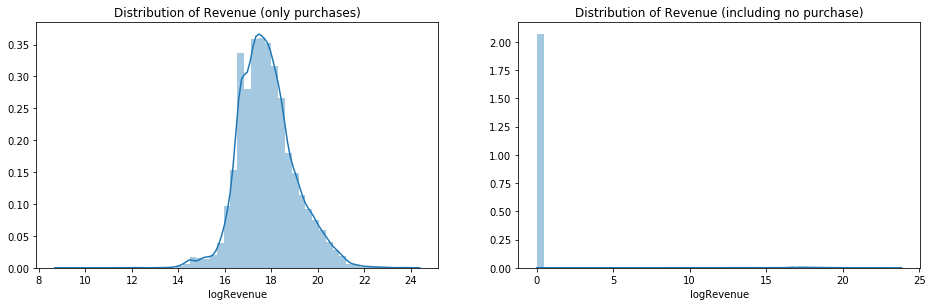

In [268]:
%matplotlib inline
fig = plt.subplots(figsize=(13, 4))
plt.tight_layout()

plt.subplot(1, 2, 1)
sns.distplot(purchase_df.logRevenue)
plt.title(f"Distribution of Revenue (only purchases)")

plt.subplot(1, 2, 2)
sns.distplot(df.logRevenue)
plt.title(f"Distribution of Revenue (including no purchase)");

Purchases are normally distributed (when log transformation is taken) but highly skewed when including visits that have not purchased. Below, we'll examine the statistical distribution of revnue per marketing channel with violin plots.

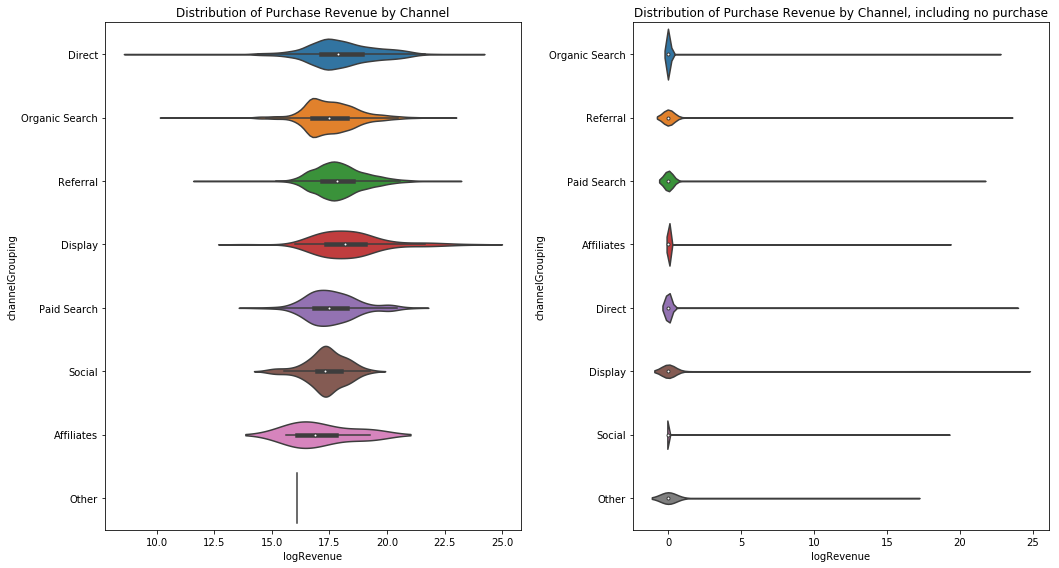

In [269]:
plt.subplots(figsize=(15,8))

plt.subplot(1,2,1)
sns.violinplot(x='logRevenue', y='channelGrouping', data=purchase_df)
plt.title('Distribution of Purchase Revenue by Channel')

plt.subplot(1,2,2)
sns.violinplot(x='logRevenue', y='channelGrouping', data=df)
plt.title('Distribution of Purchase Revenue by Channel, including no purchase')

plt.tight_layout();

While the channel types aren't necessary to determine CLV, it can be informative to see which channels impact purchase amounts the most. Display ads on average result in higher purchase revenue, while direct has the largest array of purchase revenue. 

In [270]:
# Changing date column to datetime format after 
df.date = pd.to_datetime(df.date)

In [271]:
# Creating time series to investigate seasonality
time_df = df.groupby(by=['date']).agg({'fullVisitorId':'count', 'transactionRevenue':'sum'})

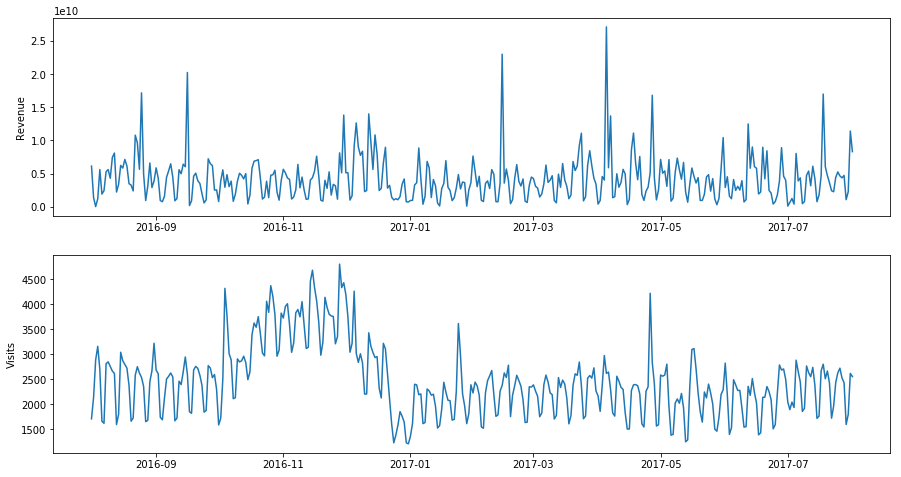

In [272]:
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(time_df.index,time_df['transactionRevenue'])
plt.ylabel('Revenue')

plt.subplot(2,1,2)
plt.plot(time_df.index,time_df['fullVisitorId'])
plt.ylabel('Visits');

The time series data shows an increase in visits and an uptick in day to day revenue around the holidays, as well as major spikes in October, February, and April, possibly coinciding with the start of internship cohorts. 

In [273]:
# Grouping by country 
country_df = df.groupby(by=['country']).agg({'fullVisitorId':'count','logRevenue': 'sum'})

In [274]:
# Sorting and identifying top ten countries based on revenue and order count
top_ten_by_rev = country_df.sort_values('logRevenue', ascending=False).head(10)
top_ten_by_count = country_df.sort_values('fullVisitorId', ascending=False).head(10)

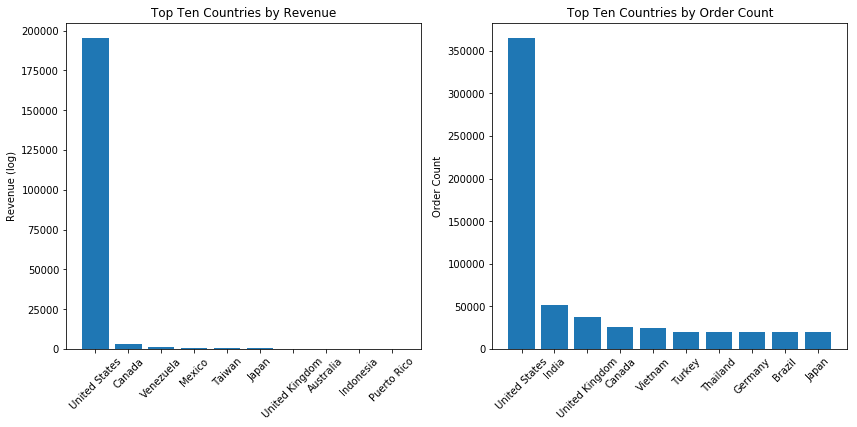

In [275]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.bar(top_ten_by_rev.index,top_ten_by_rev['logRevenue'])
plt.title('Top Ten Countries by Revenue')
plt.ylabel('Revenue (log)')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(top_ten_by_count.index,top_ten_by_count['fullVisitorId'])
plt.title('Top Ten Countries by Order Count')
plt.ylabel('Order Count')
plt.xticks(rotation=45);

Again, not necessary for the prediction of CLV, but breaking down the dataset by country can help marketers craft their message and might give even greater insight into customer segments. 

The US beats the "competition" in both sales and order count, while India is second for order count but does not place in the top ten for sales. Strategies to increase revenue from India may be to upsell or offer free shipping with purchases greater than $30.

In [276]:
customer_df = purchase_df.groupby(by=['fullVisitorId']).agg({'visitNumber':'count', 
                                                             'logRevenue':'sum'})

In [277]:
customer_df = customer_df.loc[customer_df['visitNumber'] >1]

In [278]:
print(f'{len(customer_df)} out of {len(purchase_df)} customers have made repeat purchases. ({round((len(customer_df)/len(purchase_df))*100)}% of customers)')

736 out of 11515 customers have made repeat purchases. (6% of customers)


In [279]:
print(f'The most orders made by a single customer: {customer_df.visitNumber.max()}')
print(f'The most spent by a single customer: ${round(customer_df.logRevenue.max(),2)}')

The most orders made by a single customer: 24
The most spent by a single customer: $418.29


In [280]:
## Uncomment to save dataframe consisting only of purchases

#  purchase_df.to_csv('purchase_df.csv', index=False)

# Market Segmentation and the RFM Model

In marketing, customer segmentation is the gold standard. As you understand your customers with precise detail, the more genuine your marketing rhetoric will come across. Generally, there are four ways to segment your consumer base: 

 - Demographic
 - Geographic
 - Psychographic
 - Behavioral
 
In order to supplement the web data we have from the Google Merchandise Store, we'll engineer a few features in order to 'score' each customer based on the RFM model. This technique takes the recency (R) of the last purchase, the frequency (F) of all purchases, and the monetary value (M) defined by the revenue of each customer. 

<img src="RFM.png">

Further down, we'll be using the sklearn's KMeans clustering algorithm to segment the customers. Depending on the busines objective, of which we don't have, we could have a set amount of segments to identify. For our purposes in this notebook, we'll try a technique to identify the optimal number of segments by finding the lowest sum of squared errors. 
 
*It's worth it to note that the data may NOT have identifiable clusters. Work with the data you have and make decisions that best suit the stakeholder's needs while not looking for information that isn't there.

In [319]:
# Uncomment to import purchase dataframe

df = pd.read_csv('purchase_df.csv')

In [320]:
df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,country,transactionRevenue,logRevenue
0,Direct,2016-09-02 00:00:00,6194193421514403509,1,2016-09-02 19:12:52,United States,37860000.0,17.449406
1,Organic Search,2016-09-02 00:00:00,5327166854580374902,3,2016-09-02 19:35:06,United States,306670000.0,19.541283
2,Referral,2016-09-02 00:00:00,8885051388942907862,7,2016-09-02 14:43:13,United States,68030000.0,18.035459
3,Referral,2016-09-02 00:00:00,185467632009737931,6,2016-09-02 19:59:58,United States,26250000.0,17.083177
4,Referral,2016-09-02 00:00:00,3244885836845029978,4,2016-09-02 14:00:17,United States,574150000.0,20.168401


## Feature Engineering

In [321]:

def RFM_dataframe(customer_col, purchase_date_col, revenue_col, df):
    '''
    This function takes in a previously cleaned
    dataframe and the column names for customers, 
    purchase dates, and revenue as strings.
    Returns dataframe with two engineerd columns: 
    recency, and frequency, as well as a cumulative
    revenue total for each unique
    visitor to the Google Merch Store.
    '''
    
    # Select only unique customer IDs
    cust_df = df.groupby(customer_col)
    cust_df = pd.DataFrame(df[customer_col].unique(), columns=[customer_col])
    cust_df[customer_col].astype(str)
    
    # Create Dataframe of unique visitors and most recent visit to site
    df_recency = df.groupby(customer_col)[purchase_date_col].max().reset_index()
    df_recency.columns = [customer_col,purchase_date_col]
    df_recency[purchase_date_col] = pd.to_datetime(df_recency[purchase_date_col])
    df_recency['Recency'] = (df_recency[purchase_date_col].max() - df_recency[purchase_date_col]).dt.days
    df_recency = df_recency.drop(purchase_date_col, axis=1)
    df_recency['Recency'].astype('int')
    
    # Get visit counts for each user and create dataframe
    # Frequency is determined by repeat purchases: Order count - 1
    df_frequency = df.groupby(customer_col)[purchase_date_col].count().reset_index()
    
    df_frequency.columns = [customer_col,'Frequency']
    df_frequency['Frequency'] = df_frequency['Frequency'] - 1
    
    # Get total order revenue for each unique visitor 
    df_revenue = df.groupby(customer_col)[revenue_col].mean().reset_index()
    
    # Merge data
    
    dfs = [df_frequency, df_recency, df_revenue]
    
    for e in dfs:
        cust_df = pd.merge(cust_df, e, on=customer_col)
        
    return cust_df

Above is a nifty function I created to take our cleaned dataset and engineer the necessary features for segmentation and returns a new dataframe with only the necessary features needed to segment customers using the RFM model.

In [322]:
rfm_df = RFM_dataframe('fullVisitorId', 'visitStartTime', 'logRevenue', df)

In [323]:
rfm_df.head()

,fullVisitorId,Frequency,Recency,logRevenue
0,6194193421514403509,0,333,17.449406
1,5327166854580374902,0,333,19.541283
2,8885051388942907862,2,333,18.837163
3,185467632009737931,0,333,17.083177
4,3244885836845029978,2,329,20.738062


Without assuming Google's marketing plan, I've decided to segment only those who have previously purchased. It may be beneficial to dive deeper into the behaviors of those who have not made purchases such as number of pages visited, pages on which they bounced, etc. so that you might improve your chances of them completing purchases online.

## Customer Segmentation - Unsupervised Machine Learning with Kmeans

Now that our data is ready to cluster, we'll test a few cluster levels and compare the sum of squared errors in an elbow plot to identify the best level to cluster each feature individually.

In [324]:

def SSE_plot(df, col_to_plot=False):
    '''
    This function takes in one column of
    the RFM dataframe as a string
    and will plot a KMeans elbow plot of the 
    sum of squared estimate. Where the elbow
    bends will determine how many clusters are
    optimal for the Kmeans clustering.
    '''
    sse={}
    if col_to_plot:
        km_var = df[[col_to_plot]].copy()
    else:
        km_var = df.copy()
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(km_var)
        km_var["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
#     plt.title(str(km_var))
    plt.show();
    

Frequency


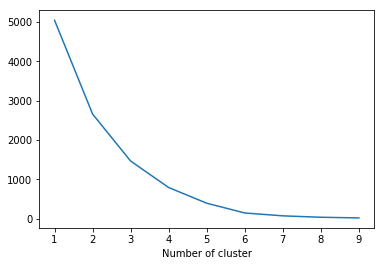

Recency


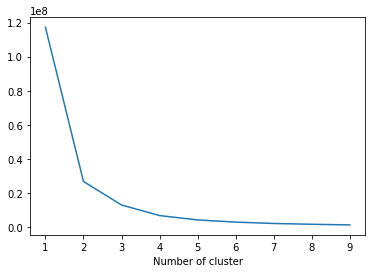

logRevenue


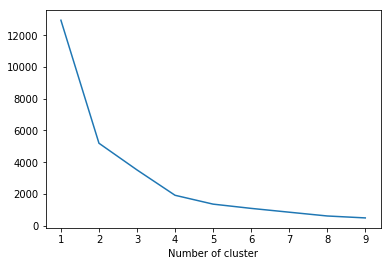

In [325]:
%matplotlib inline
for col in ['Frequency', 'Recency', 'logRevenue']:
    print(col)
    SSE_plot(rfm_df, col)

In [326]:

def order_cluster(cluster_col, feature_col, df, ascending):
    '''
    This function takes in a column of cluster
    assignments and features used to assign the 
    cluster as strings, dataframe in which clusters
    are featured, and ascending argument. Returns 
    dataframe with clusters ordered from worst to best.
    '''
    
    df_new = df.groupby(cluster_col)[feature_col].mean().reset_index()
    df_new = df_new.sort_values(by=feature_col,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_col,'index']], on=cluster_col)
    df_final = df_final.drop([cluster_col],axis=1)
    df_final = df_final.rename(columns={"index":cluster_col})
    return df_final

Below, we'll cluster based on the number identified by the SSE plots. We'll use the function above to order the clusters from worst to best and view basic statistics of each feature's cluster.

In [327]:
def frequency_cluster(cluster_number, frequency_col, dataframe):
    frequency_kmeans = KMeans(n_clusters=cluster_number)
    frequency_kmeans.fit(dataframe[[frequency_col]])
    
    # Assigning cluster prediction to customers
    dataframe['FrequencyCluster'] = frequency_kmeans.predict(dataframe[[frequency_col]])
    
    # Ordering clusters from low to high and identifying statistics
    dataframe = order_cluster('FrequencyCluster', frequency_col, dataframe, True)
    
    return dataframe

rfm_df = frequency_cluster(5, 'Frequency', rfm_df)
rfm_df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,9029.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,868.0,1.177419,0.382243,1.0,1.0,1.0,1.0,2.0
2,87.0,3.931034,1.159321,3.0,3.0,3.0,5.0,7.0
3,11.0,11.181818,2.926369,8.0,8.5,11.0,14.0,15.0
4,1.0,32.000000,NaN,32.0,32.0,32.0,32.0,32.0


In [328]:
def recency_cluster(cluster_number, recency_col, dataframe):
    recency_kmeans = KMeans(n_clusters=cluster_number)
    recency_kmeans.fit(dataframe[[recency_col]])
    
    # Assigning cluster prediction to customers
    dataframe['RecencyCluster'] = recency_kmeans.predict(dataframe[[recency_col]])
    
    # Ordering clusters from low to high and identifying statistics
    dataframe = order_cluster('RecencyCluster', recency_col, dataframe, False)
    
    return dataframe

rfm_df = recency_cluster(4, 'Recency', rfm_df)
rfm_df.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2363.0,322.810834,25.420365,277.0,300.0,325.0,346.0,365.0
1,2758.0,229.933285,25.336557,178.0,212.0,232.0,246.0,276.0
2,2451.0,125.249286,28.020042,83.0,99.0,124.0,149.0,177.0
3,2424.0,39.195132,25.070620,0.0,16.0,40.0,61.0,82.0


Having tested with the number of clusters determined by the elbow plot above, three clusters were insufficient for this dataset. Instead, I'll be using five clusters. More clusters added nuance to the revenue category, thus giving more weight to revenue when scoring overall in the following cells. 

In [329]:
def revenue_cluster(cluster_number, revenue_col, dataframe):    
    revenue_kmeans = KMeans(n_clusters=cluster_number)
    revenue_kmeans.fit(dataframe[[revenue_col]])
    
    # Assigning cluster prediction to customers
    dataframe['RevenueCluster'] = revenue_kmeans.predict(dataframe[[revenue_col]])
    
    # Ordering clusters from low to high and identifying statistics
    dataframe = order_cluster('RevenueCluster', revenue_col,dataframe,True)
    
    return dataframe

rfm_df = revenue_cluster(5, 'logRevenue', rfm_df)
rfm_df.groupby('RevenueCluster')['logRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,437.0,15.352156,0.753720,9.210440,14.975532,15.602258,15.892449,16.034714
1,2733.0,16.730047,0.280144,16.044310,16.549229,16.759423,16.972085,17.172408
2,3427.0,17.620456,0.261234,17.173540,17.375988,17.617495,17.840684,18.092038
3,2487.0,18.574199,0.327911,18.092871,18.292734,18.515900,18.826446,19.275351
4,912.0,19.985313,0.602066,19.278070,19.524161,19.813067,20.289594,23.497338


<b>
- Frequency: </b> Nearly 70% of the customers fall in the lower two clusters and there's a large gap between the minimum and maximum values of the high value cluster. 


<b>
- Recency: </b> Most customers are quite inactive (how many Google tees do you <i>really</i> need?) The window of recency gets larger the better the cluster assignment is.  

<b>
- Revenue: </b> As we saw in the EDA, the vast majority of consumers purchased, on average, 17 dollars worth of products on the Google Merchandise Store. The three revenue clusters are pretty well spaced, with no more than about 22 dollars spent in an average order. Nearly a third of all purchases are between 13 and 22 dollars. 

In [330]:
# Adding cluster numbers to identify overall score per customer

rfm_df['OverallScore'] = rfm_df['RecencyCluster'] + rfm_df['FrequencyCluster'] + rfm_df['RevenueCluster']
rfm_df.groupby('OverallScore')['Recency','Frequency','logRevenue'].mean()

,Recency,Frequency,logRevenue
OverallScore,,,
0,324.053191,0.000000,15.043949
1,301.911894,0.002937,16.529335
2,266.856333,0.015753,17.045142
3,222.403132,0.046085,17.520441
4,152.574292,0.095519,17.809328
5,103.133618,0.200732,18.213199
6,77.360714,0.328571,18.846289
7,55.302013,0.744966,19.559449
8,48.105263,2.473684,19.707337


In [331]:
# Naming and defining segments
rfm_df['Segment'] = 0
rfm_df.loc[rfm_df['OverallScore']>4,'Segment'] = 1 
rfm_df.loc[rfm_df['OverallScore']>6,'Segment'] = 2 

Again, depending on your business model, you may already have certain cutoffs for segments. Here, I've broken them down to three groups. Inactive, infrequent, low spenders are low value, mid value is higher than average revenue with average - more than average recency and average to more than average frequency, and high value customers fall into the upper eschelons of at least two features. 

In [332]:
print('Low: ', len(rfm_df.query('Segment == 0')))
print('Mid: ', len(rfm_df.query('Segment == 1')))
print('High: ', len(rfm_df.query('Segment == 2')))

Low:  7141
Mid:  2479
High:  376


In [333]:
def scatter_plot(col1, col2, df):
    '''
    This function visualizes two features
    from the RFM dataframe and color codes
    each of the final clusters.'''
    
    df = df.sample(n=2000)
    
    plt.figure(figsize=(6,4))
    
    # Low Value Segment
    plt.scatter(x=df.query("Segment == 0")[col1],
               y=df.query("Segment == 0")[col2],
               c='#440154FF',
               alpha=.5)
    
    # Mid Value Segment
    plt.scatter(x=df.query("Segment == 1")[col1],
               y=df.query("Segment == 1")[col2],
               c='#20A387FF',
               alpha=.5)
    
    # High Value Segment
    plt.scatter(x=df.query("Segment == 2")[col1],
               y=df.query("Segment == 2")[col2],
               c='#FDE725FF',
               alpha=.8)
    
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} x {col2} Clusters')
    plt.show();

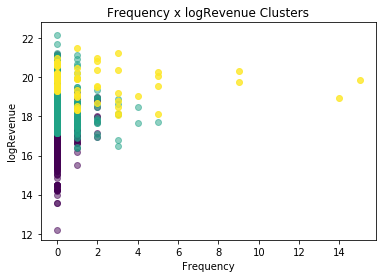

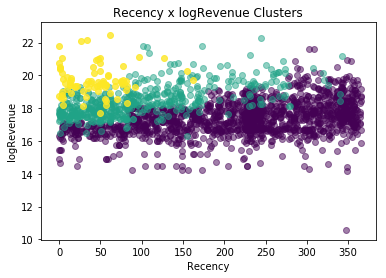

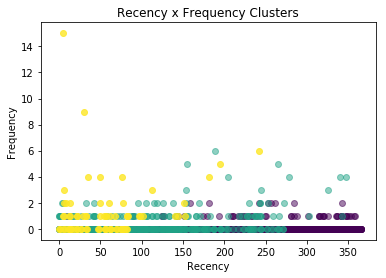

In [334]:
%matplotlib inline
scatter_plot('Frequency', 'logRevenue', rfm_df)
scatter_plot('Recency', 'logRevenue', rfm_df)
scatter_plot('Recency', 'Frequency', rfm_df)

The clusters look pretty well defined! It looks as if we were correct on our assumptions of the cluster levels. Below, we'll take a look at a 3D plot of the clusters to see behind the overlap. 

In [335]:
# Separating segments

high = rfm_df.query('Segment == 2')
mid = rfm_df.query('Segment == 1')
low = rfm_df.query('Segment == 0')

<IPython.core.display.Javascript object>


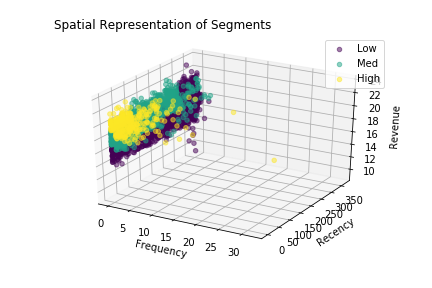

In [445]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1= (low['Frequency'].values, low['Recency'].values, low['logRevenue'].values)
g2 = (mid['Frequency'].values, mid['Recency'].values, mid['logRevenue'].values)
g3= (high['Frequency'].values, high['Recency'].values, high['logRevenue'].values)

data = [g1, g2, g3]
colors = ['#440154FF', '#20A387FF', '#FDE725FF']
groups = ['Low', 'Med', 'High']

for data, color, group in zip(data, colors, groups):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.5, c=color, label=group)

# Make legend
    ax.legend()
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Recency')
    ax.set_zlabel('Revenue')
    ax.set_title('Spatial Representation of Segments', loc='left')
    plt.show();

From this plot, we can see there are customers that have not spent a lot of money but frequently stop by the site and have made purchases recently that also fall into the high value category. Scores seem to be pulled down by either very infrequent purchases or made their last purchase far in the past. 

In [446]:
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)
%matplotlib inline

plot_data = [
    go.Scatter(
        x=rfm_df.query("Segment == 0")['OverallScore'],
        y=rfm_df.query("Segment == 0")['logRevenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= '#440154',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=rfm_df.query("Segment == 1")['OverallScore'],
        y=rfm_df.query("Segment == 1")['logRevenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= '#20A387',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=rfm_df.query("Segment == 2")['OverallScore'],
        y=rfm_df.query("Segment == 2")['logRevenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= '#FDE725',
            opacity= 0.9
           )
    )
]

plot_layout = go.Layout(
        yaxis= {'title': "LTV"},
        xaxis= {'title': "RFM Score"},
        title='Relationship between RFM and LTV'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig);

# Customer Lifetime Value 

In marketing, according to <a href="https://en.wikipedia.org/wiki/Customer_lifetime_value">Wikipedia</a>, Customer Lifetime Value (CLV) can be defined as "a prediction of the net profit attributed to the entire future relationship with a customer." CLV is an important metric to track as it can help identify your customer acquisition budget, help your marketing team to segment your customer base, increase retention and satisfaction, etc. CLV is represented as a dollar amount and varies customer to customer. 

<img src="brandwise-clv-bellcurve.gif">

Customer lifetime value can be predicted with the <a href="http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf"> BG/NBD (Beta Geometric Negative Binomial Distribution) model.</a> Luckily, there's a Python package called <a href="https://pypi.org/project/Lifetimes/">Lifetimes</a> designed by Cameron Davidson-Pilon, former Director of Data Science at Shopify, that will do the heavy lifting for us. You can find the documentation 

Before we move on, there are a few basic assumptions of the BG/NBD model to undestand. 

## Assumptions
<b> 1. For active customers, puchases made during time period <i>t </i> follow a Poisson Distribution with mean <i> λt<i>.

For example, if λ = 3:

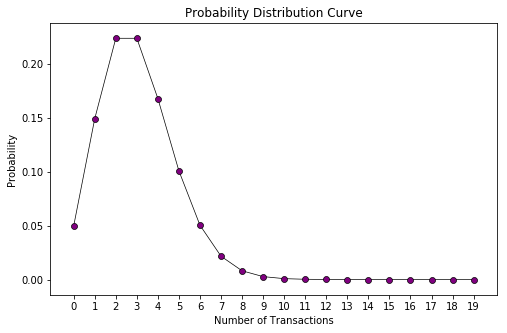

In [338]:
%matplotlib inline

probability = []
poisson_distribution = poisson(3)

for transaction in range(20):
    probability.append(poisson_distribution.pmf(transaction))
    
plt.figure(figsize=(8,5))
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve')
plt.plot(probability, color='black', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability, color='purple', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()

<b> 2. The differences between rates of transaction for multiple customers follows a gamma distribution with shape <i>r</i> and scale <i>a</i>.

For a group of 50 customers where r = 8 and a = 0.8: 

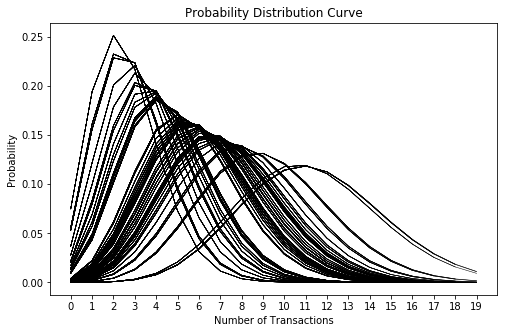

In [339]:

plt.figure(figsize=(8,5))

for customer in range(50):
    probability = []
    poisson_distribution = poisson(np.random.gamma(shape=8, scale=0.8))

    for transaction in range(20):
        probability.append(poisson_distribution.pmf(transaction))
        
        plt.plot(probability, color='black', linewidth=0.5, zorder=1)
        
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')    
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve');

<b> 3. The probability of customers becoming inactive after each purchase has a probability of <i>p</i>. 

<b> 4. The variation in individual customer's posibility of becoming inactive follows a Beta distribution with two shape parameters - α and β.

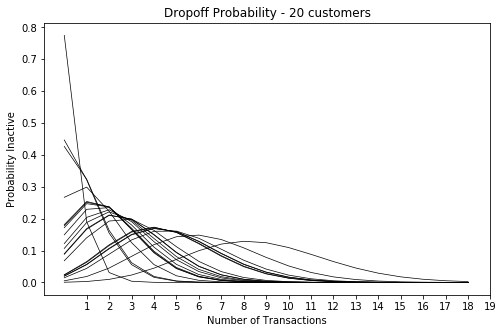

In [340]:
a = 1
b = 2.5

plt.figure(figsize=(8,5))

for customer in range(0, 20):
    probability_arr = []
    poisson_distribution = poisson(np.random.gamma(shape=8, scale=0.8))
    
    beta = np.random.beta(a=a, b=b)
    cumulative_beta = 0
    
    for transaction in range(1,20): 
        
        proba = poisson_distribution.pmf(transaction)
        cumulative_beta = beta + cumulative_beta - (beta * cumulative_beta)
        inactive_probability = 1 - cumulative_beta
        proba *= inactive_probability
        probability_arr.append(proba)
        
    probability_arr = np.array(probability_arr)
    probability_arr /= probability_arr.sum()
    plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)


plt.ylabel('Probability Inactive')
plt.xlabel('Number of Transactions')
plt.xticks(range(1, 20))
plt.title('Dropoff Probability - 20 customers');

<b> 5. Each customer has an individual and independent transaction rate and dropoff probability.

## Feature Engineering

If your dataset does not have features representing the three elements of RFM and the age of the customer, Lifetimes has a built in method. However, there is one major difference between our preprocessing method from before and that of the Lifetimes package:

<b>The Lifetimes package determines that the monetary value is reduced to zero if the customer has not made more than one purchase. </b> 

Our segments and the predicted purchase power of the following models will vary slightly. However, segmentation will influence language of marketing assets, while CLV will influence advertising budgets. 

In [372]:
# Using Lifetimes' built in preprocessing method on cleaned dataset on only purchase data
df = pd.read_csv('purchase_df.csv')
# purchases = df.query('logRevenue > 0')
data = summary_data_from_transaction_data(purchases, 
                                          'fullVisitorId', 
                                          'visitStartTime', 
                                          monetary_value_col='logRevenue', 
                                          observation_period_end=df.visitStartTime.max())
data.head()

,frequency,recency,T,monetary_value
fullVisitorId,,,,
213131142648941,0.0,0.0,96.0,0.0
435324061339869,0.0,0.0,285.0,0.0
562678147042735,0.0,0.0,100.0,0.0
585708896049892,0.0,0.0,224.0,0.0
670722016498267,0.0,0.0,23.0,0.0


The dataset we'll be working with from now on includes the following features (from the documentation):

- <b>frequency</b> represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
<br><br>
- <b>T</b> represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
<br><br>
- <b>recency</b> represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
<br><br>
- <b>monetary_value</b> represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

## Basic Analysis with the BG/NBD Model

The Lifetimes package has many functions to plot the data, once the processed dataframe has been fit with the BG/NBD model. The plots offer an overview of purchase habits of customers on the whole.

In [373]:
from lifetimes import BetaGeoFitter

# Instantiating BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# Fitting model to frequency, recency, and days since first purchase
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 9996 subjects, a: 1.89, alpha: 4.57, b: 0.88, r: 0.03>


Once the model is fit, you can see values for a, alpha, b, and r that can then be input in the assumption plots from earlier to view purchase probabilities of your specific customer base. By calling the summary method, you can investigate each of these parameters in detail, as seen below. 

You can also exercise the use of the penalizer coefficient if your dataset is small to punish large parameters.

In [374]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.028360,0.001255,0.025901,0.030820
alpha,4.572573,0.477173,3.637313,5.507832
a,1.888537,0.305243,1.290260,2.486813
b,0.882509,0.172185,0.545026,1.219993


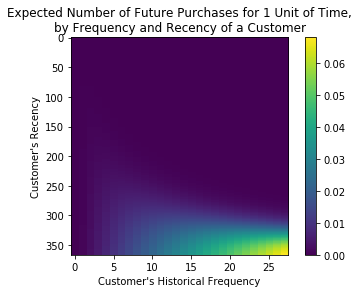

In [375]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf);

Our Frequency/Recency Matrix shows us where our 'hot' and 'cold' customers fall in the spectrum. Our 'hottest' customers are in the yellow range, having purchased over 25 times and are nearly a year old. The 'coldest' customers you'll find on the top right, that may have purchased a lot but are extremely new. As we know from our assumptions, the rate of transaction peaks early on and drops off swiftly, so if they purchased a lot quickly but not recently, they're most likely a lost cause. 

Also notice the lighter blue/purple around the 10 mark; customers that fall into this category have made purchases recently but not frequently, so their value to the company can be tricky to decipher. They've been great customers in the past, but will they fall off or continue making purchases? The following plot vizualises the probability that a customer is still "alive" in relation to their purchase recency and frequency.

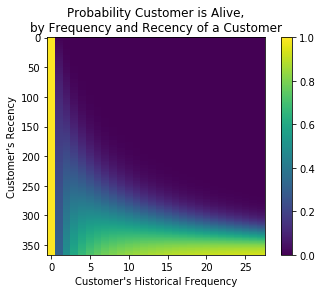

In [376]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

The likelihood of a customer being alive is increased by age and more frequent purchases, though the plot indicates age is a stronger predictor.

Next, we'll predict number of purchases for individual customers by calling the model's "conditional_expected_number_of_purchases_up_to_time" method. Depending on your business model, your 't' can be whatever timespan you choose. 

In [377]:
# Purchase prediction for the next 30 days
t = 30

# Make predictions
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                      data['frequency'],
                                                                                      data['recency'], 
                                                                                      data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
fullVisitorId,,,,,
5772921781547143127,2.0,26.0,27.0,18.540675,0.603248
608915197735218105,11.0,261.0,266.0,20.797058,0.923668
7311242886083854158,11.0,264.0,265.0,20.164759,0.952218
4984366501121503466,15.0,288.0,294.0,19.851406,1.186878
9417857471295131045,4.0,15.0,20.0,20.918673,1.214540


The table above gives us an idea of how many purchases we can expect from the top five customers, with the best customer expected to make at least one purchase in the next thirty days.

The following function simulates data from the fitted model and makes purchase predictions on the simulated data, then plots against the actual purchase data. 

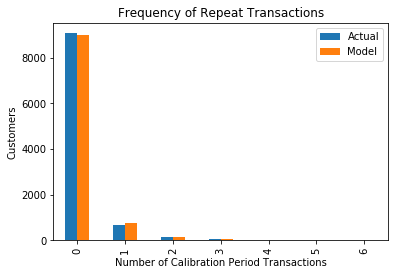

In [378]:
from lifetimes.plotting import plot_period_transactions
%matplotlib inline
plot_period_transactions(bgf)

Our model doesn't look too shabby! The model overestimated the number of customers that would end up purchasing exactly one item, but matched the number almost exactly for other transaction amounts.

Below, we'll do a type of training/testing on our data. Because we don't have future looking data, we'll use the first six months of purchases to predict the next six months. This function is similar to the BetaGeoFitter we fit earlier, however it fits the model on purchases in a calibration period while "holding" another subset of data similar to a test set. 

In [388]:
from lifetimes.utils import calibration_and_holdout_data

# Creating dataset on purchase data NOT RFM dataset
purchases.visitStartTime = pd.to_datetime(purchases.visitStartTime)
summary_cal_holdout = calibration_and_holdout_data(purchases, 
                                                   'fullVisitorId', 
                                                   'visitStartTime',
                                                   calibration_period_end= '2017-02-02 00:00:00')   

You can look at the first few rows of the summary to view the RFM parameters of each customer for only the calibration period. 

In [389]:
summary_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
fullVisitorId,,,,,
435324061339869,0.0,0.0,104.0,0.0,181
585708896049892,0.0,0.0,43.0,0.0,181
1123528056036404,0.0,0.0,52.0,0.0,181


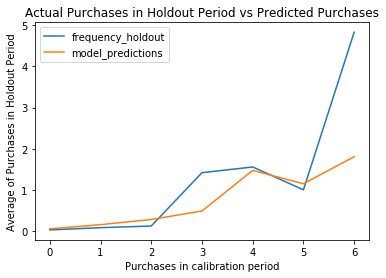

In [390]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

With six months of calibration data beginning August of 2016 to February of 2017, the model was somewhat successful at predicting purchases of the holdout data, from February to August, 2017. The model underestimates average of purchases at 3, overestimates between 3 and 4 purchases, and again underestimates above 5. This may be explained by seasonality of customer behavior, considering the calibration period spanned over the winter holidays. 

If you want to look at a specific customer's probability of being alive, you can use the Lifetimes package's plot_history_alive function that shows a beautiful representation of purchase frequency and the dropoff probability as discussed in the assumptions section. In order to visualize a customer's history, you need to use a dataframe containing datapoints for indivisual transactions, not aggregate data. Here's the code, checking out one customer's history: 

In [351]:
# Importing dataframe with individual transaction data
df = pd.read_csv('cleaned_df.csv')

# Counting days between first purchase and end of dataset
df.visitStartTime = pd.to_datetime(df.visitStartTime)
days_since_birth = np.abs(df.loc[df['fullVisitorId']==6849604863010168468].visitStartTime.min()- df.visitStartTime.max()).days

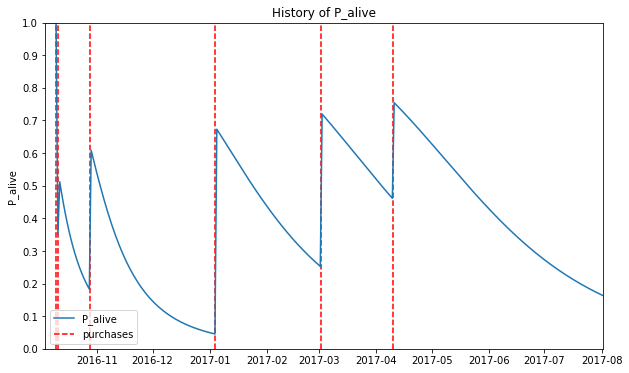

In [352]:
from lifetimes.plotting import plot_history_alive

fig = plt.figure(figsize=(10,6))
sp_trans = df.loc[df['fullVisitorId']==6849604863010168468]
plot_history_alive(bgf, days_since_birth, sp_trans, 'visitStartTime');

By the end of the dataset, this specific customer has about a 20% chance of being alive. 

## Customer Lifetime Value with the Gamma Gamma Model

Finally, we'll run an unsupervised model to predict the economic value of each transaction. According to the author of the Lifetimes package, "The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency." 

Before we continue, we must check the Pearson correlation between frequency and monetary value and only move forward if the vectors are close to 0. 

In [396]:
# Model cannot predict future purchases if a purchase hasn't been made
data = data.query('monetary_value > 0')

In [397]:
data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.145768
frequency,0.145768,1.000000


The correlation between frequency and monetary value is low, so we can move forward with fitting the model.

In [402]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = .01)

ggf.fit(data['frequency'],
        data['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 923 subjects, p: 4.73, q: 1.50, v: 4.17>


Finally, we can calculate the individual customer's lifetime value. We'll call the 'customer_lifetime_value' method on the fitted Gamma Gamma model, input our BG/NBD model, RFM parameters and age column, and the lifetime expected for the user in months.

In [413]:
CLV = ggf.customer_lifetime_value(bgf, data['frequency'], data['recency'], data['T'], data['monetary_value'], time=12)

In [416]:
# Combining with RFM dataframe 
data = data.join(CLV, on='fullVisitorId')

In [417]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases,clv
fullVisitorId,,,,,,
6173812362189693,1.0,1.0,343.0,19.012183,0.000563,0.136925
9046037663524262,1.0,17.0,169.0,18.490020,0.008492,1.356510
14262055593378383,2.0,18.0,36.0,16.607432,0.244886,13.772008
16925875208939543,1.0,12.0,34.0,17.117992,0.095558,7.270321
19814677684676098,1.0,36.0,240.0,17.735303,0.008153,1.373164


At this point, our work here is done! The marketing department will use this data to drive their budget and language decisions in a far more effective manner. 

# Future Work

1. Customer lifetime value is forward looking. Comparisons should be made to determine effectiveness of the model in predicting purchases once new data is gathered. 
<br><br>
2. Market segments may need to be reevaluated once an attempt has been made by the marketing department to run differing campaigns. An A/B test should be used to determine effectiveness.
<br><br>
3. This is only one strategy in which to calculate CLV. There are linear regression models that should be tested to compare. 